<a href="https://colab.research.google.com/github/ichi-ta/gci2022winter/blob/main/competition_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

In [107]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

## データの加工

In [108]:
train = pd.read_csv("/content/train.csv")
test  = pd.read_csv("/content/test.csv")
#sample_sub = pd.read_csv("/content/drive/MyDrive/GCI2022Winter/competition2/sample_submission.csv")

In [109]:
train = train.drop(["OCCUPATION_TYPE","EXT_SOURCE_1","EXT_SOURCE_3"], axis=1)
test = test.drop(["OCCUPATION_TYPE","EXT_SOURCE_1","EXT_SOURCE_3"], axis=1)

In [110]:
train.columns[36:48]

Index(['LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_2',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object')

エンコードや欠損値の補完を行っている。

In [111]:
organization_ce = train['ORGANIZATION_TYPE'].value_counts()
train['ORGANIZATION_TYPE'] = train['ORGANIZATION_TYPE'].map(organization_ce)
test['ORGANIZATION_TYPE'] = test['ORGANIZATION_TYPE'].map(organization_ce)

#平均値で欠損値を補完
for f in train.columns[36:51]:
  train[f].fillna(train[f].mean(), inplace=True)
  test[f].fillna(test[f].mean(), inplace=True)

train['AMT_GOODS_PRICE'].fillna(train['AMT_GOODS_PRICE'].mean(), inplace=True)
test['AMT_GOODS_PRICE'].fillna(test['AMT_GOODS_PRICE'].mean(), inplace=True)

train["CNT_FAM_MEMBERS"].fillna(train["CNT_FAM_MEMBERS"].mean(), inplace=True)
test["CNT_FAM_MEMBERS"].fillna(test["CNT_FAM_MEMBERS"].mean(), inplace=True)

#中央値で欠損値を補完
train["AMT_ANNUITY"].fillna(train["AMT_ANNUITY"].median(), inplace=True)
test["AMT_ANNUITY"].fillna(test["AMT_ANNUITY"].median(), inplace=True)

In [112]:
#One Hot Encoding
train.loc[train["OWN_CAR_AGE"] >= 60, "OWN_CAR_AGE"] = np.nan
test.loc[test["OWN_CAR_AGE"] >= 60, "OWN_CAR_AGE"] = np.nan

train["OWN_CAR_AGE"] = train["OWN_CAR_AGE"] // 10
test["OWN_CAR_AGE"] = test["OWN_CAR_AGE"] // 10

train_car_age_ohe = pd.get_dummies(train['OWN_CAR_AGE']).add_prefix("OWN_CAR_AGE_")
test_car_age_ohe = pd.get_dummies(test['OWN_CAR_AGE']).add_prefix("OWN_CAR_AGE_")

train = pd.concat([train, train_car_age_ohe], axis=1)
test = pd.concat([test, test_car_age_ohe], axis=1)

train.drop('OWN_CAR_AGE', axis=1, inplace=True)
test.drop('OWN_CAR_AGE', axis=1, inplace=True)

In [113]:
#Label Encoding
le = LabelEncoder()
le_features = train.select_dtypes(include="object").columns[:10]
for feature in le_features:
  train[feature] = le.fit_transform(train[feature].values)
  test[feature]  = le.fit_transform(test[feature].values)

In [114]:
train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,OWN_CAR_AGE_0.0,OWN_CAR_AGE_1.0,OWN_CAR_AGE_2.0,OWN_CAR_AGE_3.0,OWN_CAR_AGE_4.0,OWN_CAR_AGE_5.0
0,0,0,0,0,0,0,0,112500.0,755190.0,36328.5,...,0.006652,0.268418,0.267547,1.903644,0,0,0,0,0,0
1,1,0,0,0,0,1,0,225000.0,585000.0,16893.0,...,0.000000,0.000000,0.000000,1.000000,0,0,0,0,0,0
2,2,0,0,0,0,1,0,54000.0,334152.0,18256.5,...,0.006652,0.268418,0.267547,1.903644,0,0,0,0,0,0
3,3,0,0,0,0,1,0,67500.0,152820.0,8901.0,...,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0
4,4,1,0,1,0,0,0,157500.0,271066.5,21546.0,...,0.000000,0.000000,0.000000,4.000000,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171197,171197,0,0,1,2,2,0,83250.0,404325.0,20772.0,...,0.000000,0.000000,1.000000,0.000000,0,0,1,0,0,0
171198,171198,0,0,0,1,1,0,247500.0,601470.0,29065.5,...,0.000000,0.000000,1.000000,5.000000,1,0,0,0,0,0
171199,171199,0,0,0,0,0,2,292500.0,1237684.5,49216.5,...,0.000000,0.000000,0.000000,1.000000,0,0,0,0,0,0
171200,171200,0,0,1,1,0,0,112500.0,239850.0,25186.5,...,0.006652,0.268418,0.267547,1.903644,1,0,0,0,0,0


## Variance Threshold
分散をしきい値として特徴量を選択

In [115]:
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold()
sel.fit_transform(X_select)

array([[0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [2.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [1.71199e+05, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.71200e+05, 0.00000e+00, 1.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.71201e+05, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00]])

In [116]:
X_new = pd.DataFrame(sel.fit_transform(X_select), columns=X_select.columns.values[sel.get_support()])
print('Before Feature Selection:', X_select.shape)
print('After Feature Selection:', X_new.shape)

result = pd.DataFrame(sel.get_support(), index=X_select.columns.values, columns=['False: dropped'])
result['variance'] = sel.variances_
print(result)

Before Feature Selection: (171202, 52)
After Feature Selection: (171202, 52)
                             False: dropped      variance
SK_ID_CURR                             True  1.712010e+05
NAME_CONTRACT_TYPE                     True  8.573745e-02
CODE_GENDER                            True  2.252778e-01
FLAG_OWN_CAR                           True  6.202575e-01
FLAG_OWN_REALTY                        True  4.437834e-01
CNT_CHILDREN                           True  5.185954e-01
AMT_INCOME_TOTAL                       True  1.347390e+07
AMT_CREDIT                             True  4.005000e+06
AMT_ANNUITY                            True  2.560455e+05
AMT_GOODS_PRICE                        True  4.005000e+06
NAME_TYPE_SUITE                        True  3.146668e+00
NAME_INCOME_TYPE                       True  6.481835e+00
NAME_EDUCATION_TYPE                    True  1.686400e+00
NAME_FAMILY_STATUS                     True  1.366639e+00
NAME_HOUSING_TYPE                      True  9.052451

すべて選択されてしまい、意味がなかった。

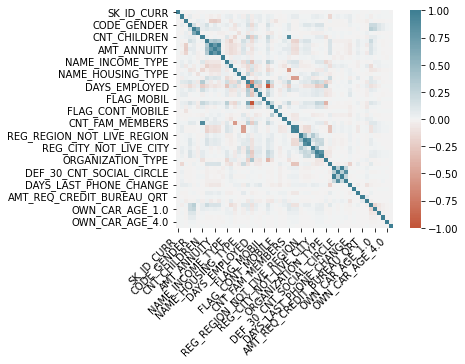

In [117]:
corr = train.corr(method='pearson')
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
); 

## [Embedded Method](https://qiita.com/FukuharaYohei/items/db88a8f4c4310afb5a0d#3-embedded-method)
参考にして特徴量選択を行った。

In [118]:
X_select = train.drop("TARGET", axis=1)
y_select = train["TARGET"]
target = train["TARGET"].values

### L1正則化線形モデル

In [119]:
from sklearn.feature_selection import SelectFromModel

In [120]:
#L1正則化線形モデル
from sklearn.svm import LinearSVC
svc = LinearSVC(C=0.01, penalty="l1", dual=False)

selector = SelectFromModel(svc)

X_new_svc = pd.DataFrame(selector.fit_transform(X_select, train['TARGET']), 
                     columns=X_select.columns.values[selector.get_support()])
result_svc = pd.DataFrame(selector.get_support(), index=X_select.columns.values, columns=['False: dropped'])
result_svc['coef'] = selector.estimator_.coef_[0]  # Linearモデル用
print(result_svc)

                             False: dropped          coef
SK_ID_CURR                            False  2.598918e-08
NAME_CONTRACT_TYPE                     True -4.142554e-02
CODE_GENDER                            True  5.751240e-02
FLAG_OWN_CAR                           True -4.268553e-03
FLAG_OWN_REALTY                       False  0.000000e+00
CNT_CHILDREN                           True  4.109126e-02
AMT_INCOME_TOTAL                      False  1.043639e-08
AMT_CREDIT                            False  3.722629e-07
AMT_ANNUITY                           False  1.337961e-06
AMT_GOODS_PRICE                       False -4.596850e-07
NAME_TYPE_SUITE                        True  1.061986e-03
NAME_INCOME_TYPE                       True  2.887581e-03
NAME_EDUCATION_TYPE                    True  1.595660e-02
NAME_FAMILY_STATUS                     True -1.234559e-02
NAME_HOUSING_TYPE                      True  2.464530e-03
REGION_POPULATION_RELATIVE            False  0.000000e+00
DAYS_BIRTH    

In [121]:
use_features_svc = result_svc[result_svc['False: dropped'] == True].index
use_features_svc

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'CNT_CHILDREN',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_ID_PUBLISH',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'OWN_CAR_AGE_0.0', 'OWN_CAR_AGE_1.0', 'OWN_CAR_AGE_2.0'],
      dtype='object')

In [122]:
train_svc = train[use_features_svc]
train_svc["TARGET"] = target
test_svc = test[use_features_svc]

In [123]:
drop_features_svc = ["OBS_30_CNT_SOCIAL_CIRCLE","AMT_REQ_CREDIT_BUREAU_YEAR"]
train_svc = train.drop(drop_features_svc, axis=1)
test_svc  = test.drop(drop_features_svc, axis=1)

<AxesSubplot:>

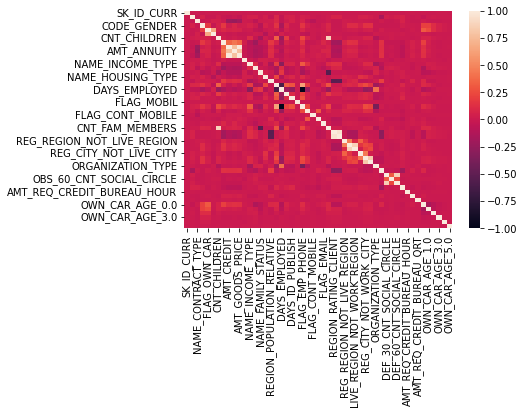

In [124]:
cor = train_svc.corr()
sns.heatmap(cor,vmin = -1, vmax = 1)

In [125]:
X_svc = train_svc.drop("TARGET", axis=1).values
y_svc = train_svc["TARGET"].values
X_test_svc = test_svc.values

#標準化
ss = StandardScaler()
ss.fit(X_svc)
X_std_svc = ss.transform(X_svc)
X_test_std_svc = ss.transform(X_test_svc)

X_train_svc, X_valid_svc, y_train_svc, y_valid_svc = train_test_split(X_std_svc, y_svc, test_size=0.3, stratify=y_svc, random_state=0)

In [126]:
# LogisticRegression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=0)
lr.fit(X_train_svc, y_train_svc)

lr_train_pred_svc = lr.predict_proba(X_train_svc)[:, 1]
lr_valid_pred_svc = lr.predict_proba(X_valid_svc)[:, 1]
print(f"Train Score: {roc_auc_score(y_train_svc, lr_train_pred_svc)}")
print(f"Valid Score: {roc_auc_score(y_valid_svc, lr_valid_pred_svc)}")

Train Score: 0.7068790152291203
Valid Score: 0.7043001605234014


In [127]:
# MLPClassifier
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=0)
mlp.fit(X_train_svc, y_train_svc)

mlp_train_pred_svc = mlp.predict_proba(X_train_svc)[:, 1]
mlp_valid_pred_svc = mlp.predict_proba(X_valid_svc)[:, 1]
print(f"Train Score: {roc_auc_score(y_train_svc, mlp_train_pred_svc)}")
print(f"Valid Score: {roc_auc_score(y_valid_svc, mlp_valid_pred_svc)}")

Train Score: 0.8124328383743753
Valid Score: 0.6645178967271015


In [128]:
# LGBMClassifier
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(
    max_bin=200,
    min_data_in_leaf=20,
    min_sum_hessian_in_leaf=1e-3,
    max_depth=5,
    subsample=0.5,
    min_child_weight=15
    )
lgb.fit(X_train_svc, y_train_svc)

lgb_train_pred_svc = lgb.predict_proba(X_train_svc)[:, 1]
lgb_valid_pred_svc = lgb.predict_proba(X_valid_svc)[:, 1]
print(f"Train Score: {roc_auc_score(y_train_svc, lgb_train_pred_svc)}")
print(f"Valid Score: {roc_auc_score(y_valid_svc, lgb_valid_pred_svc)}")

Train Score: 0.7823352956527291
Valid Score: 0.7188696859860255


In [129]:
# XGBClassifier
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=0)
xgb.fit(X_train_svc, y_train_svc)

xgb_train_pred_svc = xgb.predict_proba(X_train_svc)[:, 1]
xgb_valid_pred_svc = xgb.predict_proba(X_valid_svc)[:, 1]
print(f"Train Score: {roc_auc_score(y_train_svc, xgb_train_pred_svc)}")
print(f"Valid Score: {roc_auc_score(y_valid_svc, xgb_valid_pred_svc)}")

Train Score: 0.8787263650659018
Valid Score: 0.7057472210315233


### ランダムフォレスト分類

In [130]:
#ランダムフォレスト分類
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

selector = SelectFromModel(rf) # 中央値以上の特徴量を選択

X_new_rf = pd.DataFrame(selector.fit_transform(X_select, train["TARGET"]), 
                     columns=X_select.columns.values[selector.get_support()])
result_rf = pd.DataFrame(selector.get_support(), index=X_select.columns.values, columns=['False: dropped'])
result_rf['featureImportances'] = selector.estimator_.feature_importances_  # Random Forest用
print(result_rf)

                             False: dropped  featureImportances
SK_ID_CURR                             True            0.059188
NAME_CONTRACT_TYPE                    False            0.002827
CODE_GENDER                           False            0.006889
FLAG_OWN_CAR                          False            0.011469
FLAG_OWN_REALTY                       False            0.012987
CNT_CHILDREN                          False            0.011228
AMT_INCOME_TOTAL                       True            0.043427
AMT_CREDIT                             True            0.049912
AMT_ANNUITY                            True            0.055002
AMT_GOODS_PRICE                        True            0.040936
NAME_TYPE_SUITE                       False            0.010804
NAME_INCOME_TYPE                      False            0.008769
NAME_EDUCATION_TYPE                   False            0.009106
NAME_FAMILY_STATUS                    False            0.016459
NAME_HOUSING_TYPE                     Fa

In [131]:
use_features_rf = result_rf[result_rf['False: dropped'] == True].index
use_features_rf

Index(['SK_ID_CURR', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'ORGANIZATION_TYPE', 'EXT_SOURCE_2', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object')

In [132]:
train_rf = train[use_features_rf]
train_rf["TARGET"] = target
test_rf = test[use_features_rf]

In [133]:
drop_features_rf = ["DAYS_EMPLOYED","DAYS_REGISTRATION","AMT_ANNUITY","OBS_30_CNT_SOCIAL_CIRCLE","AMT_REQ_CREDIT_BUREAU_YEAR"]
train_rf = train_rf.drop(drop_features_rf, axis=1)
test_rf = test_rf.drop(drop_features_rf, axis=1)

<AxesSubplot:>

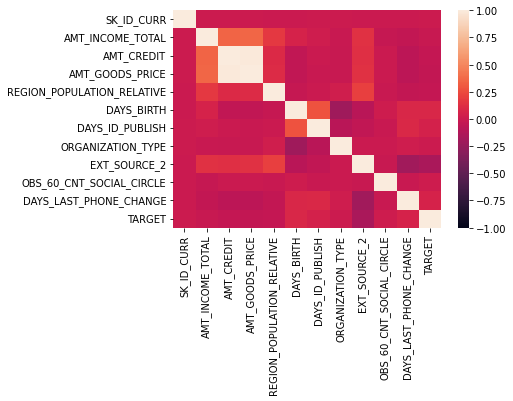

In [134]:
cor = train_rf.corr()
sns.heatmap(cor,vmin = -1, vmax = 1)

In [135]:
X_rf = train_rf.drop("TARGET", axis=1).values
y_rf = train_rf["TARGET"].values
X_test_rf = test_rf.values

#標準化
ss = StandardScaler()
ss.fit(X_rf)
X_std_rf = ss.transform(X_rf)
X_test_std_rf = ss.transform(X_test_rf)

X_train_rf, X_valid_rf, y_train_rf, y_valid_rf = train_test_split(X_std_rf, y_rf, test_size=0.3, stratify=y_rf, random_state=0)

In [136]:
# LogisticRegression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=0)
lr.fit(X_train_rf, y_train_rf)

lr_train_pred_rf = lr.predict_proba(X_train_rf)[:, 1]
lr_valid_pred_rf = lr.predict_proba(X_valid_rf)[:, 1]
print(f"Train Score: {roc_auc_score(y_train_rf, lr_train_pred_rf)}")
print(f"Valid Score: {roc_auc_score(y_valid_rf, lr_valid_pred_rf)}")

Train Score: 0.6832253567449376
Valid Score: 0.6831421003743537


In [137]:
# MLPClassifier
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=0)
mlp.fit(X_train_rf, y_train_rf)

mlp_train_pred_rf = mlp.predict_proba(X_train_rf)[:, 1]
mlp_valid_pred_rf = mlp.predict_proba(X_valid_rf)[:, 1]
print(f"Train Score: {roc_auc_score(y_train_rf, mlp_train_pred_rf)}")
print(f"Valid Score: {roc_auc_score(y_valid_rf, mlp_valid_pred_rf)}")

Train Score: 0.7082214216450711
Valid Score: 0.6898411363399632


In [138]:
# LGBMClassifier
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(
    max_bin=200,
    min_data_in_leaf=20,
    min_sum_hessian_in_leaf=1e-3,
    max_depth=5,
    subsample=0.5,
    min_child_weight=15
    )
lgb.fit(X_train_rf, y_train_rf)

lgb_train_pred_rf = lgb.predict_proba(X_train_rf)[:, 1]
lgb_valid_pred_rf = lgb.predict_proba(X_valid_rf)[:, 1]
print(f"Train Score: {roc_auc_score(y_train_rf, lgb_train_pred_rf)}")
print(f"Valid Score: {roc_auc_score(y_valid_rf, lgb_valid_pred_rf)}")

Train Score: 0.7549932103870876
Valid Score: 0.700023509171412


In [139]:
# XGBClassifier
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=0)
xgb.fit(X_train_rf, y_train_rf)

xgb_train_pred_rf = xgb.predict_proba(X_train_rf)[:, 1]
xgb_valid_pred_rf = xgb.predict_proba(X_valid_rf)[:, 1]
print(f"Train Score: {roc_auc_score(y_train_rf, xgb_train_pred_rf)}")
print(f"Valid Score: {roc_auc_score(y_valid_rf, xgb_valid_pred_rf)}")

Train Score: 0.8479237280681571
Valid Score: 0.6831138096765527


# まとめ
L1正則化線形モデルを用いたほうがランダムフォレスト分類よりも精度がよい